In [19]:
%pylab inline
import scipy
from scipy.sparse import coo_matrix, block_diag, identity, hstack
#import matplotlib as mpl
import matplotlib.pyplot as plt
from pyiga import bspline, vform, geometry, vis, solvers, utils, topology
from pyiga import assemble
#from patchmesh import *
from sksparse.cholmod import cholesky
#from patchmesh3D import *
#from multipatch import *

from pyiga import bspline
from pyiga import utils
from pyiga.bspline import BSplineFunc
from pyiga.tensor import apply_tprod
from pyiga import adaptive as adap

import functools
import itertools

numpy.set_printoptions(linewidth=100000)
numpy.set_printoptions(precision=5)

Populating the interactive namespace from numpy and matplotlib


/home/wolfman/anaconda3/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['cholesky', 'hstack', 'identity']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [20]:
def draw_loglog_slope(fig, ax, origin, width_inches, slope, inverted=False, color=None, polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None):
    """
    This function draws slopes or "convergence triangles" into loglog plots.
    @param fig: The figure
    @param ax: The axes object to draw to
    @param origin: The 2D origin (usually lower-left corner) coordinate of the triangle
    @param width_inches: The width in inches of the triangle
    @param slope: The slope of the triangle, i.e. order of convergence
    @param inverted: Whether to mirror the triangle around the origin, i.e. whether 
        it indicates the slope towards the lower left instead of upper right (defaults to false)
    @param color: The color of the of the triangle edges (defaults to default color)
    @param polygon_kwargs: Additional kwargs to the Polygon draw call that creates the slope
    @param label: Whether to enable labeling the slope (defaults to true)
    @param labelcolor: The color of the slope labels (defaults to the edge color)
    @param label_kwargs: Additional kwargs to the Annotation draw call that creates the labels
    @param zorder: The z-order value of the triangle and labels, defaults to a high value
    """

    if polygon_kwargs is None:
        polygon_kwargs = {}
    if label_kwargs is None:
        label_kwargs = {}

    if color is not None:
        polygon_kwargs["color"] = color
    if "linewidth" not in polygon_kwargs:
        polygon_kwargs["linewidth"] = 0.75 * mpl.rcParams["lines.linewidth"]
    if labelcolor is not None:
        label_kwargs["color"] = labelcolor
    if "color" not in label_kwargs:
        label_kwargs["color"] = polygon_kwargs["color"]
    if "fontsize" not in label_kwargs:
        label_kwargs["fontsize"] = 0.75 * mpl.rcParams["font.size"]

    if inverted:
        width_inches = -width_inches
    if zorder is None:
        zorder = 10

    # For more information on coordinate transformations in Matplotlib see
    # https://matplotlib.org/3.1.1/tutorials/advanced/transforms_tutorial.html

    # Convert the origin into figure coordinates in inches
    origin_disp = ax.transData.transform(origin)
    origin_dpi = fig.dpi_scale_trans.inverted().transform(origin_disp)

    # Obtain the top-right corner in data coordinates
    corner_dpi = origin_dpi + width_inches * np.array([1.0, 0.0])
    corner_disp = fig.dpi_scale_trans.transform(corner_dpi)
    corner = ax.transData.inverted().transform(corner_disp)

    (x1, y1) = (origin[0], origin[1])
    x2 = corner[0]

    # The width of the triangle in data coordinates
    width = x2 - x1
    # Compute offset of the slope
    log_offset = y1 / (x1 ** (-slope))

    y2 = log_offset * (x2 ** (-slope))
    height = y2 - y1

    # The vertices of the slope
    a = origin
    b = corner
    c = [x2, y2]

    # Draw the slope triangle
    X = np.array([a, b, c])
    triangle = plt.Polygon(X[:3,:], fill=False, zorder=zorder, **polygon_kwargs)
    ax.add_patch(triangle)

    # Convert vertices into display space
    a_disp = ax.transData.transform(a)
    b_disp = ax.transData.transform(b)
    c_disp = ax.transData.transform(c)

    # Figure out the center of the triangle sides in display space
    bottom_center_disp = a_disp + 0.5 * (b_disp - a_disp)
    bottom_center = ax.transData.inverted().transform(bottom_center_disp)

    right_center_disp = b_disp + 0.5 * (c_disp - b_disp)
    right_center = ax.transData.inverted().transform(right_center_disp)

    # Label alignment depending on inversion parameter
    va_xlabel = "bottom" if not inverted else "top"
    ha_ylabel = "left" if not inverted else "right"

    # Label offset depending on inversion parameter
    offset_xlabel = [0.0, 0.33 * label_kwargs["fontsize"]] if not inverted else [0.0, -0.33 * label_kwargs["fontsize"]]
    offset_ylabel = [0.33 * label_kwargs["fontsize"], 0.0] if not inverted else [-0.33 * label_kwargs["fontsize"], 0.0]

    # Draw the slope labels
    ax.annotate("$1$", bottom_center, xytext=offset_xlabel, textcoords='offset points', ha="center", va=va_xlabel, zorder=zorder, **label_kwargs)
    ax.annotate(f"${slope}$", right_center, xytext=offset_ylabel, textcoords='offset points', ha=ha_ylabel, va="center", zorder=zorder, **label_kwargs)


In [21]:
def adaptive(M, nu, j, Ma_T, theta=0.9, maxiter=12, plotrange=(-1,1), draw=False):
    params=dict()
    numdofs=np.zeros(maxiter)
    L2err=np.zeros(maxiter)
    H1err=np.zeros(maxiter)
    err_est=np.zeros(maxiter)
    err_indicator=[]
    refined=[]
    P = []
    #params['u_sol']=u_sol
    # params['ux']=ux
    # params['uy']=uy
    MP = assemble.Multipatch(M, automatch = True)
    
    for iter in range(maxiter):
        print(iter)
        if draw:
            fig = plt.figure()
            MP.mesh.draw(fig, knots=False)
            plt.axis('scaled');
            plt.show()
        
        # ---------------------------------------------------------------------
        # SOLVE
        # ---------------------------------------------------------------------
        
        numdofs[iter] = MP.numdofs
        #implement Dirichlet boundary conditions
        
#         print(MP.Basis.shape)
#         print(MP.numdofs)
        bcs = MP.compute_dirichlet_bcs({0:0})
        #print(bcs)

        # assemble the linear system
        Kh = sum([MP.assemble_volume(vform.stiffness_vf(2,a=nu[k]),domain_id=k) for k in nu])
        F = sum([MP.assemble_volume('j * v + inner(Ma_T, grad(v)) * dx', arity=1, domain_id=k, Ma_T=Ma_T[k], j=j[k], physical=True) for k in ['M1','M2']],axis=0)

        #eliminate boundary conditions
        LS = assemble.RestrictedLinearSystem(Kh, F, bcs)
        #solve system and L2 project exact solution into discrete space
        uh = LS.complete((cholesky(LS.A))(LS.b))
        #u_ = (cholesky(Mh))(u_rhs)
        #print(check_coupling(MP,u_))
        
        #eh=uh-u_
        #L2err[iter] = sqrt(eh.T@Mh@eh)
        #H1err[iter] = sqrt(eh.T@Kh@eh + L2err[iter]**2)
        
        # ---------------------------------------------------------------------
        # ESTIMATE AND REFINE
        # ---------------------------------------------------------------------
        
        if iter < maxiter-1:
            start=time.time()
            err_indicator.append(adap.PoissonEstimator(MP,uh,f=j,a=nu, M=Ma_T, physical=True))
            err_est[iter] = norm(err_indicator[-1])
            marked_patches = adap.doerfler_marking(err_indicator[-1], theta)
            end = time.time()
            print("Estimate and Marking took " + str(end - start) + " seconds.")
            
            marked_patches = {p:None for p in marked_patches}
            refined.append(marked_patches)
            #print(MP.numdofs)
            start = time.time()
            P_i = MP.patch_refine(h_ref=marked_patches, return_P = True)
            for i in range(len(P)):
                P[i]=P_i@P[i]
            P.append(P_i)
            end = time.time()
            print("Refinement took " + str(end - start) + " seconds.")
            
            # start=time.time()
            # MP = assemble.Multipatch(M, automatch = True)
            # end = time.time()
            print("Basis setup took " + str(end-start) + " seconds.")
            #MP.patch_refine(patches=marked_patches, return_prol=False)
            #MP.mesh.draw(patch_idx=True)
            #uh = [geometry.BSplineFunc(MP.mesh.patches[p][0][0], MP.global_to_patch(p) @ u_) for p in range(len(MP.mesh.patches))]
        

    # restrict solution to each individual patch
    #uh = [geometry.BSplineFunc(MP.mesh.patches[p][0][0], MP.global_to_patch(p) @ u_) for p in range(len(MP.mesh.patches))]

    #for (uh, ((kvs, geo),_)) in zip(uh, MP.mesh.patches):
        #vis.plot_field(uh, geo, vmin=plotrange[0], vmax=plotrange[1])
    #plt.axis('scaled')
    #plt.colorbar();
    
    return MP, uh, numdofs, L2err, H1err, err_est, err_indicator, refined, P

In [22]:
def Motor(deg,N,full=False):
    X=(bspline.make_knots(deg,0.0,1.0,3*N),)+3*(bspline.make_knots(deg,0.0,1.0,N),)+(bspline.make_knots(deg,0.0,1.0,2*N),)
    Y=2*(bspline.make_knots(deg,0.0,1.0,N),)+(bspline.make_knots(deg,0.0,1.0,3*N),)+3*(bspline.make_knots(deg,0.0,1.0,N),)+(bspline.make_knots(deg,0.0,1.0,3*N),)+2*(bspline.make_knots(deg,0.0,1.0,N),)
    kvs=list(itertools.product(X,Y))
    kvs=[(kv1,kv0) for kv0, kv1 in kvs]
    #kvs = 45*[2 * (bspline.make_knots(deg, 0.0, 1.0, N),),]
    a,b,c,d,e,f=.3,1.,1.1,1.15,1.16,1.5
    th_m,th_air,th_fe=31.,2.,5. # 2*th_m + 4*th_air + 2*th_fe = 90!!!
    geos=[
        geometry.annulus(r1=a,r2=b,phi=2*pi*th_fe/360),
        geometry.annulus(r1=a,r2=b,phi=2*pi*th_air/360).rotate_2d(2*pi*th_fe/360),
        geometry.annulus(r1=a,r2=b,phi=2*pi*th_m/360).rotate_2d(2*pi*(th_air+ th_fe)/360),                   
        geometry.annulus(r1=a,r2=b,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m+th_air+th_fe)/360),            
        geometry.annulus(r1=a,r2=b,phi=2*pi*2*th_fe/360).rotate_2d(2*pi*(th_m+th_air*2+th_fe)/360),           
        geometry.annulus(r1=a,r2=b,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m+th_air*2+th_fe*3)/360),     
        geometry.annulus(r1=a,r2=b,phi=2*pi*th_m/360).rotate_2d(2*pi*(th_m+th_air*3+th_fe*3)/360),       
        geometry.annulus(r1=a,r2=b,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m*2+th_air*3+th_fe*3)/360),   
        geometry.annulus(r1=a,r2=b,phi=2*pi*th_fe/360).rotate_2d(2*pi*(th_m*2+th_air*4+th_fe*3)/360),    
        
        geometry.annulus(r1=b,r2=c,phi=2*pi*th_fe/360),
        geometry.annulus(r1=b,r2=c,phi=2*pi*th_air/360).rotate_2d(2*pi*th_fe/360),
        geometry.annulus(r1=b,r2=c,phi=2*pi*th_m/360).rotate_2d(2*pi*(th_air+ th_fe)/360),                   
        geometry.annulus(r1=b,r2=c,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m+th_air+th_fe)/360),            
        geometry.annulus(r1=b,r2=c,phi=2*pi*2*th_fe/360).rotate_2d(2*pi*(th_m+th_air*2+th_fe)/360),           
        geometry.annulus(r1=b,r2=c,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m+th_air*2+th_fe*3)/360),     
        geometry.annulus(r1=b,r2=c,phi=2*pi*th_m/360).rotate_2d(2*pi*(th_m+th_air*3+th_fe*3)/360),       
        geometry.annulus(r1=b,r2=c,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m*2+th_air*3+th_fe*3)/360),   
        geometry.annulus(r1=b,r2=c,phi=2*pi*th_fe/360).rotate_2d(2*pi*(th_m*2+th_air*4+th_fe*3)/360), 
        
        geometry.annulus(r1=c,r2=d,phi=2*pi*th_fe/360),
        geometry.annulus(r1=c,r2=d,phi=2*pi*th_air/360).rotate_2d(2*pi*th_fe/360),
        geometry.annulus(r1=c,r2=d,phi=2*pi*th_m/360).rotate_2d(2*pi*(th_air+ th_fe)/360),                   
        geometry.annulus(r1=c,r2=d,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m+th_air+th_fe)/360),            
        geometry.annulus(r1=c,r2=d,phi=2*pi*2*th_fe/360).rotate_2d(2*pi*(th_m+th_air*2+th_fe)/360),           
        geometry.annulus(r1=c,r2=d,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m+th_air*2+th_fe*3)/360),     
        geometry.annulus(r1=c,r2=d,phi=2*pi*th_m/360).rotate_2d(2*pi*(th_m+th_air*3+th_fe*3)/360),       
        geometry.annulus(r1=c,r2=d,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m*2+th_air*3+th_fe*3)/360),   
        geometry.annulus(r1=c,r2=d,phi=2*pi*th_fe/360).rotate_2d(2*pi*(th_m*2+th_air*4+th_fe*3)/360), 
        
        geometry.annulus(r1=d,r2=e,phi=2*pi*th_fe/360),
        geometry.annulus(r1=d,r2=e,phi=2*pi*th_air/360).rotate_2d(2*pi*th_fe/360),
        geometry.annulus(r1=d,r2=e,phi=2*pi*th_m/360).rotate_2d(2*pi*(th_air+ th_fe)/360),                   
        geometry.annulus(r1=d,r2=e,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m+th_air+th_fe)/360),            
        geometry.annulus(r1=d,r2=e,phi=2*pi*2*th_fe/360).rotate_2d(2*pi*(th_m+th_air*2+th_fe)/360),           
        geometry.annulus(r1=d,r2=e,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m+th_air*2+th_fe*3)/360),     
        geometry.annulus(r1=d,r2=e,phi=2*pi*th_m/360).rotate_2d(2*pi*(th_m+th_air*3+th_fe*3)/360),       
        geometry.annulus(r1=d,r2=e,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m*2+th_air*3+th_fe*3)/360),   
        geometry.annulus(r1=d,r2=e,phi=2*pi*th_fe/360).rotate_2d(2*pi*(th_m*2+th_air*4+th_fe*3)/360), 
        
        geometry.annulus(r1=e,r2=f,phi=2*pi*th_fe/360),
        geometry.annulus(r1=e,r2=f,phi=2*pi*th_air/360).rotate_2d(2*pi*th_fe/360),
        geometry.annulus(r1=e,r2=f,phi=2*pi*th_m/360).rotate_2d(2*pi*(th_air+ th_fe)/360),                   
        geometry.annulus(r1=e,r2=f,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m+th_air+th_fe)/360),            
        geometry.annulus(r1=e,r2=f,phi=2*pi*2*th_fe/360).rotate_2d(2*pi*(th_m+th_air*2+th_fe)/360),           
        geometry.annulus(r1=e,r2=f,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m+th_air*2+th_fe*3)/360),     
        geometry.annulus(r1=e,r2=f,phi=2*pi*th_m/360).rotate_2d(2*pi*(th_m+th_air*3+th_fe*3)/360),       
        geometry.annulus(r1=e,r2=f,phi=2*pi*th_air/360).rotate_2d(2*pi*(th_m*2+th_air*3+th_fe*3)/360),   
        geometry.annulus(r1=e,r2=f,phi=2*pi*th_fe/360).rotate_2d(2*pi*(th_m*2+th_air*4+th_fe*3)/360),
    ]

    Fe = {0,1,2,3,4,5,6,7,8,9,13,17,18,19,20,21,22,23,24,25,26,36,37,38,39,40,41,42,43,44}
    Air={10,12,14,16,27,28,29,30,31,32,33,34,35}
    M1={11}
    M2={15}

    if full:
        kvs=4*kvs
        Fe = set().union(*[{x + 45*i for x in Fe} for i in range(4)])
        Air = set().union(*[{x + 45*i for x in Air} for i in range(4)])
        M1 = set().union(*[{x + 45*i for x in M1} for i in range(4)])
        M2 = set().union(*[{x + 45*i for x in M2} for i in range(4)])
        geos = [g for g in geos] + [g.rotate_2d(pi/2) for g in geos] + [g.rotate_2d(pi) for g in geos] + [g.rotate_2d(3/2*pi) for g in geos]

    patches = [(k, g) for k, g in zip(kvs,geos)]
    patches = [(tuple(bspline.mapto(k[d],lambda x: g.support[d][1]*x + g.support[d][0]*(1-x)) for d in range(2)), g) for k, g in zip(kvs,geos)]
    #patches = [(k, g) for k, g in zip(kvs,geos)]

    t=time.time()
    M = topology.PatchMesh(patches, domains={'M1':M1,'M2':M2,'Fe':Fe,'Air':Air})
    print('Detecting interfaces took ' + str(time.time()-t) + ' seconds.')
    
    M.rename_boundary(0,'D')
    if not full:                            #periodic boundary conditions
        M.set_boundary_id({'N':{(0,0),(9,0),(18,0),(27,0),(36,0),(8,1),(17,1),(26,1),(35,1),(44,1)}})
        #M.add_interface(0 ,0,0,8 ,1,0,(False,))
        #M.add_interface(9 ,0,0,17,1,0,(False,))
        #M.add_interface(18,0,0,26,1,0,(False,))
        #M.add_interface(27,0,0,35,1,0,(False,))
        #M.add_interface(36,0,0,44,1,0,(False,))
    return M
#M.set_boundary_id({'D1':{(0,2),(8,2),(16,2),(24,2)}})
#M.set_boundary_id({'D2':{(7,3),(15,3),(23,3),(31,3)}})

In [23]:
rho=1.28

nu = {'M1': 1e7/(4.344*pi), 'M2':1e7/(4.344*pi), 'Fe':1e5/(204*pi), 'Air': 1e7/(4*pi)}
#nu = {'M1': 1., 'M2': 1., 'Fe': 1., 'Air': 1.}

Ma_T = {'M1': lambda x,y: tuple(rho*nu['M1']*np.array([-y,x])/sqrt(x**2+y**2)), 
        'M2':lambda x,y: tuple(rho*nu['M2']*np.array([y,-x])/sqrt(x**2+y**2)), 
        'Fe':lambda x,y: (0.,0.), 
        'Air': lambda x,y: (0.,0.)}

j = {'M1': lambda x,y: 0.0, 'M2':lambda x,y: 0.0, 'Fe':lambda x,y: 0.0, 'Air': lambda x,y: 0.0}

In [144]:
deg=4
M=Motor(deg,deg+1)

Detecting interfaces took 2.640103578567505 seconds.


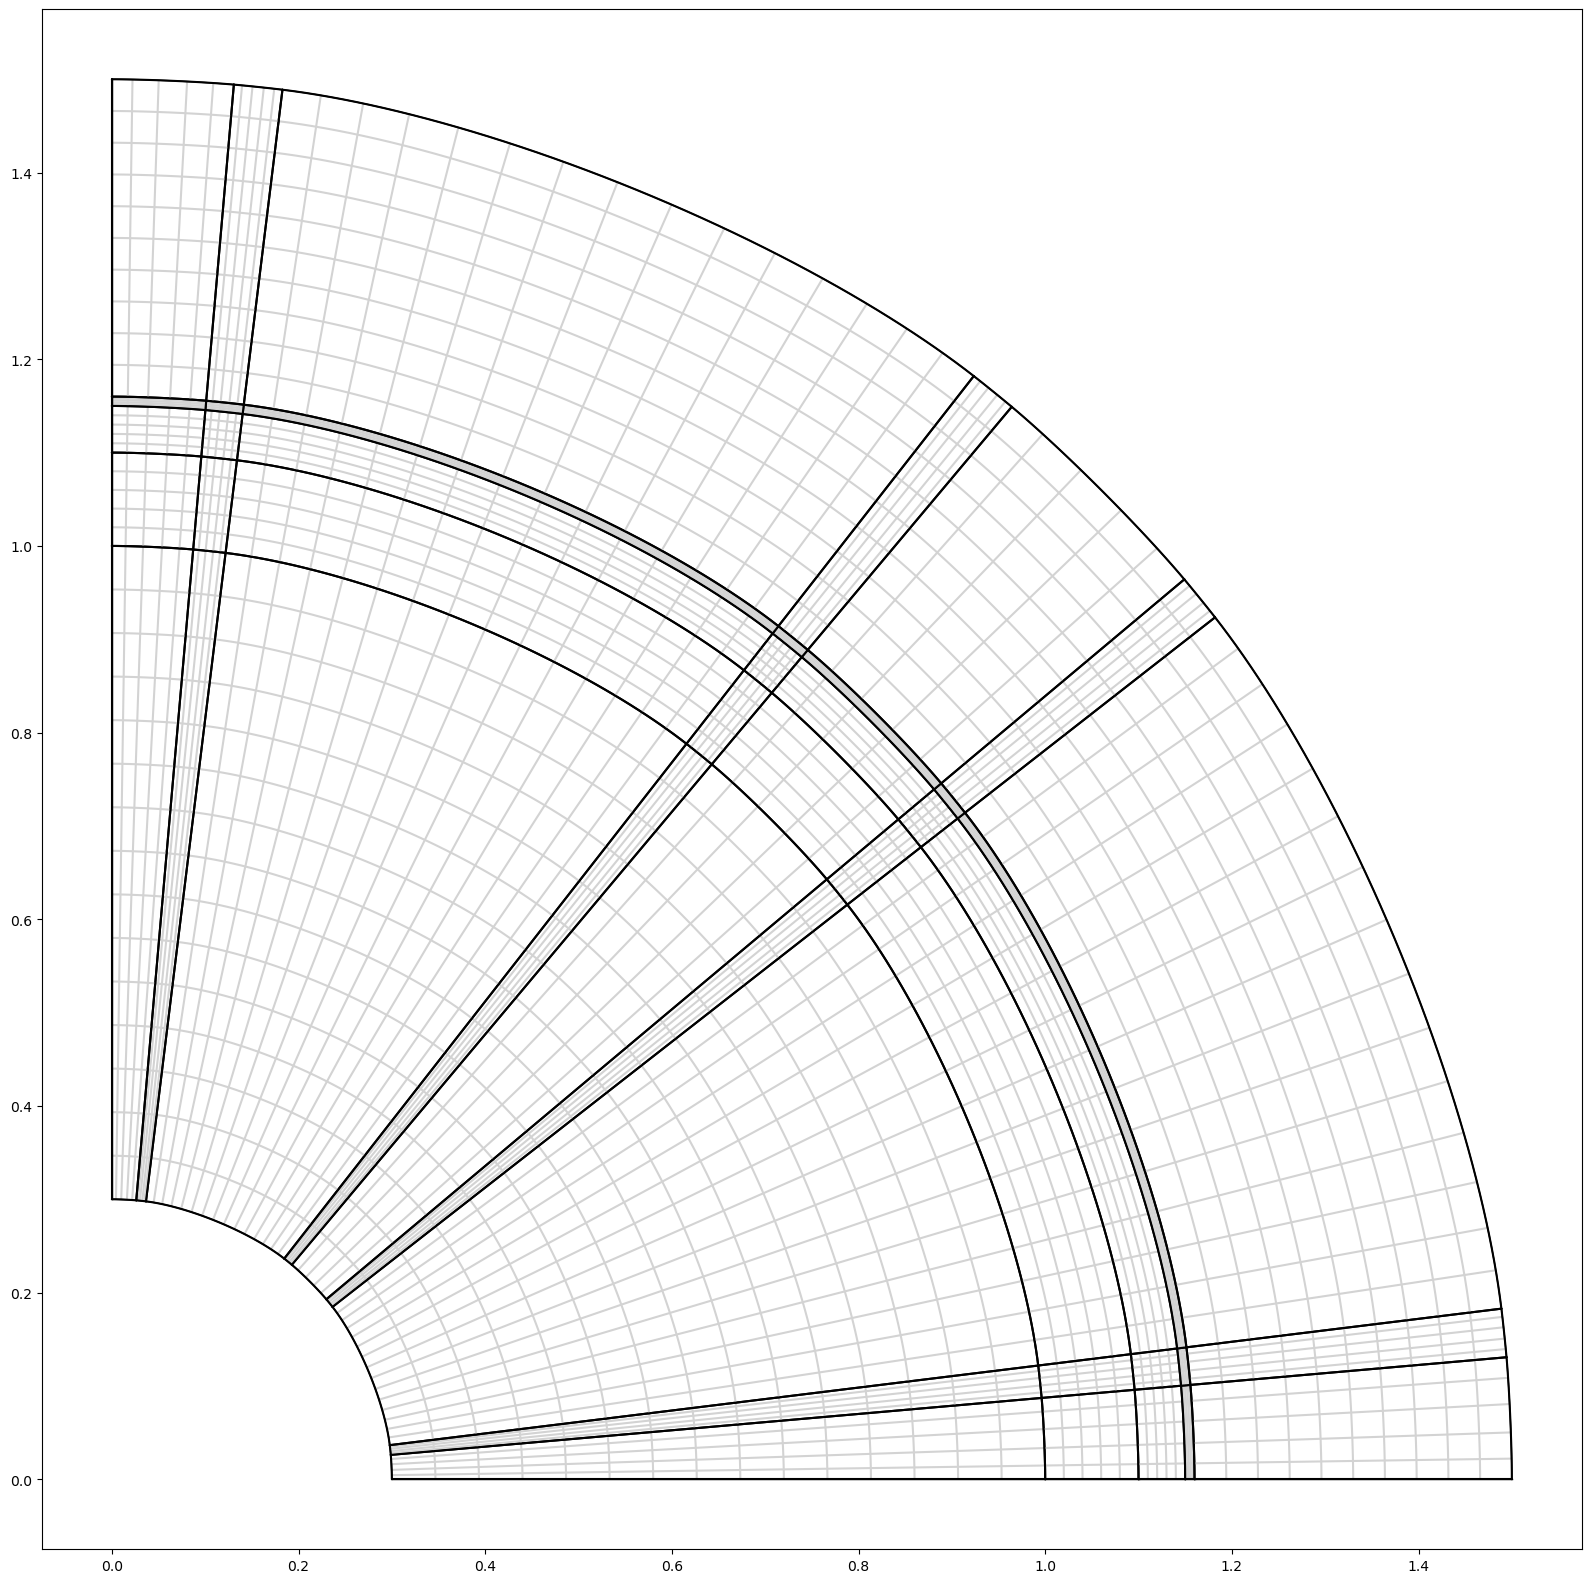

In [145]:
M.draw(knots=True, figsize=(20,20))#color={'M1':'yellow', 'M2':'yellow','Fe':'darkgrey','Air':'white'},bcolor={'D':'blue','N':'red'})

In [28]:
deg=4
M=Motor(deg,deg+1)
MP = assemble.Multipatch(M, automatch=True)
maxiter=[7,6,6]
uh=[]
numdofs = np.zeros(maxiter[deg-2],dtype=float)
P=[]
return_P = True

for i in range(maxiter[deg-2]):
    print(i)
    numdofs[i] = MP.numdofs
    print(MP.numdofs)
    bcs = MP.compute_dirichlet_bcs({'D':0.})
    t=time.time()
    Ah = sum([MP.assemble_volume(vform.stiffness_vf(2,a=nu[k]),domain_id=k) for k in nu])
    F = sum([MP.assemble_volume('(j * v - inner(Ma_T, grad(v))) * dx', arity=1, domain_id=k, Ma_T=Ma_T[k], j=j[k], physical=True) for k in j],axis=0)
    Kh = MP.assemble_volume(vform.stiffness_vf(2))
    Mh = MP.assemble_volume(vform.mass_vf(2))
    LS = assemble.RestrictedLinearSystem(Ah, F, bcs)
    print('assembly took '+str(time.time()-t)+' seconds.')
    t=time.time()
    uh.append(LS.complete((cholesky(LS.A.tocsc()))(LS.b)))
    print('solving took '+str(time.time()-t)+' seconds.')
    
    if i < maxiter[deg-2]-2 :
        P.append(MP.h_refine(h_ref=-1, return_P=return_P))
    elif i == maxiter[deg-2]-2:
        P.append(MP.p_refine(p_inc=1, return_P=return_P))
    else:
        pass
    MP.sanity_check()
    
for k in reversed(range(1,len(P))):
    P[k-1]=P[k]@P[k-1]
    
L2err = np.zeros(maxiter[deg-2])
H1err = np.zeros(maxiter[deg-2])
Aherr = np.zeros(maxiter[deg-2])
for i in range(len(uh)-1):
    eh = P[i]@uh[i]-uh[-1]
    L2err[i] = eh @ Mh @ eh
    H1err[i] = eh @ Kh @ eh + L2err[-1]
    Aherr[i] = eh @ Ah @ eh
    
L2err = sqrt(L2err)
H1err = sqrt(H1err)
Aherr = sqrt(Aherr)

np.savetxt('Mp'+str(deg)+'n'+str(deg+1)+'uni.txt', np.c_[[numdofs,H1err,L2err,Aherr]])

Detecting interfaces took 2.523030996322632 seconds.
Basis setup took 0.01647353172302246 seconds
0
5208
assembly took 1.1489317417144775 seconds.
solving took 0.0178070068359375 seconds.
Refinement took 0.0015292167663574219 seconds for 45 patches.
Basis setup took 0.022617101669311523 seconds
Prolongation took 0.09094381332397461 seconds
1
15168
assembly took 1.89449143409729 seconds.
solving took 0.06574058532714844 seconds.
Refinement took 0.001630544662475586 seconds for 45 patches.
Basis setup took 0.04467296600341797 seconds
Prolongation took 0.1192934513092041 seconds
2
50688
assembly took 3.8496780395507812 seconds.
solving took 0.25252556800842285 seconds.
Refinement took 0.002698659896850586 seconds for 45 patches.
Basis setup took 0.10209846496582031 seconds
Prolongation took 0.17913246154785156 seconds
3
184128
assembly took 10.142468929290771 seconds.
solving took 1.0553646087646484 seconds.
Refinement took 0.0020127296447753906 seconds for 45 patches.
Basis setup took 0.

In [56]:
deg=4
M_geo=Motor(deg,deg+1)
MP_geo = assemble.Multipatch(M_geo, automatch=True)
maxiter=[20,15,15]
uh_geo=[]
numdofs_geo = np.zeros(maxiter[deg-2],dtype=float)
P=[]
return_P = True

for i in range(maxiter[deg-2]):
    print(i)
    numdofs_geo[i] = MP_geo.numdofs
    print(MP_geo.numdofs)
    bcs = MP_geo.compute_dirichlet_bcs({'D':0.})
    t=time.time()
    Ah = sum([MP_geo.assemble_volume(vform.stiffness_vf(2,a=nu[k]),domain_id=k) for k in nu])
    F = sum([MP_geo.assemble_volume('(j * v - inner(Ma_T, grad(v))) * dx', arity=1, domain_id=k, Ma_T=Ma_T[k], j=j[k], physical=True) for k in j],axis=0)
    Kh = MP_geo.assemble_volume(vform.stiffness_vf(2))
    Mh = MP_geo.assemble_volume(vform.mass_vf(2))
    LS = assemble.RestrictedLinearSystem(Ah, F, bcs)
    print('assembly took '+str(time.time()-t)+' seconds.')
    t=time.time()
    uh_geo.append(LS.complete((cholesky(LS.A.tocsc()))(LS.b)))
    print('solving took '+str(time.time()-t)+' seconds.')
    
    if i < maxiter[deg-2]-2 :
        if i%5 == 0:
            P.append(MP_geo.h_refine(h_ref=-1, return_P=return_P))
        else:
            P.append(MP_geo.h_refine(h_ref='q', return_P=return_P))
    elif i == maxiter[deg-2]-2:
        P.append(MP_geo.p_refine(p_inc=1, return_P=return_P))
    else:
        pass
    MP_geo.sanity_check()
    
for k in reversed(range(1,len(P))):
    P[k-1]=P[k]@P[k-1]
    
L2err_geo = np.zeros(maxiter[deg-2])
H1err_geo = np.zeros(maxiter[deg-2])
Aherr_geo = np.zeros(maxiter[deg-2])
for i in range(len(uh_geo)-1):
    eh = P[i]@uh_geo[i]-uh_geo[-1]
    L2err_geo[i] = eh @ Mh @ eh
    H1err_geo[i] = eh @ Kh @ eh + L2err_geo[-1]
    Aherr_geo[i] = eh @ Ah @ eh
    
L2err_geo = sqrt(L2err_geo)
H1err_geo = sqrt(H1err_geo)
Aherr_geo = sqrt(Aherr_geo)

np.savetxt('Mp'+str(deg)+'n'+str(deg+1)+'geo.txt', np.c_[[numdofs_geo,H1err_geo,L2err_geo,Aherr_geo]])

Detecting interfaces took 2.6435112953186035 seconds.
Basis setup took 0.016388654708862305 seconds
0
5208
assembly took 1.258974552154541 seconds.
solving took 0.01766204833984375 seconds.
Refinement took 0.0016009807586669922 seconds for 45 patches.
Basis setup took 0.0247344970703125 seconds
Prolongation took 0.1077272891998291 seconds
1
15168
assembly took 2.0496575832366943 seconds.
solving took 0.07200288772583008 seconds.
Refinement took 0.0016398429870605469 seconds for 45 patches.
Basis setup took 0.028039932250976562 seconds
Prolongation took 0.09426569938659668 seconds
2
18656
assembly took 2.2985999584198 seconds.
solving took 0.07943868637084961 seconds.
Refinement took 0.00171661376953125 seconds for 45 patches.
Basis setup took 0.029547929763793945 seconds
Prolongation took 0.0951378345489502 seconds
3
22504
assembly took 2.570155620574951 seconds.
solving took 0.09991788864135742 seconds.
Refinement took 0.001708984375 seconds for 45 patches.
Basis setup took 0.03198719

Detecting interfaces took 2.611280679702759 seconds.
Basis setup took 0.015542030334472656 seconds


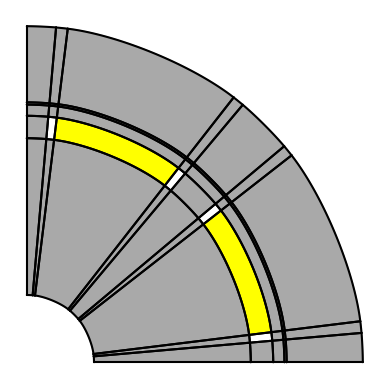

0
Residual contributions took 0.39777541160583496 seconds.
Jump contributions took 0.5967044830322266 seconds.
Refinement took 0.0614321231842041 seconds for 8 patches.
Basis setup took 0.029881715774536133 seconds
Prolongation took 0.06064009666442871 seconds


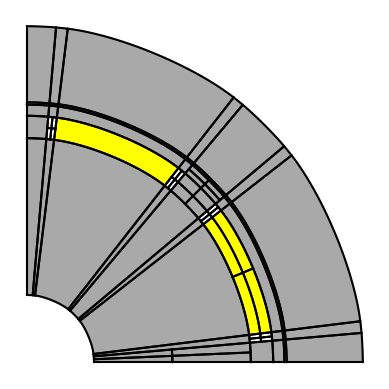

1
Residual contributions took 0.5718414783477783 seconds.
Jump contributions took 1.1241893768310547 seconds.
Refinement took 0.13947296142578125 seconds for 17 patches.
Basis setup took 0.05449724197387695 seconds
Prolongation took 0.12805843353271484 seconds


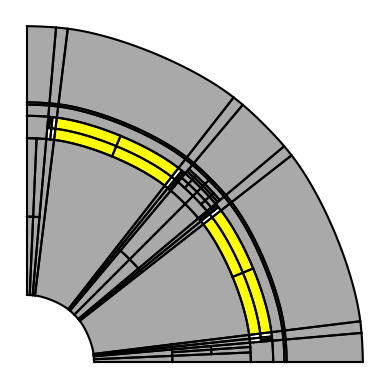

2
Residual contributions took 0.9916591644287109 seconds.
Jump contributions took 2.1144816875457764 seconds.
Refinement took 0.27884697914123535 seconds for 23 patches.
Basis setup took 0.08613920211791992 seconds
Prolongation took 0.17115473747253418 seconds


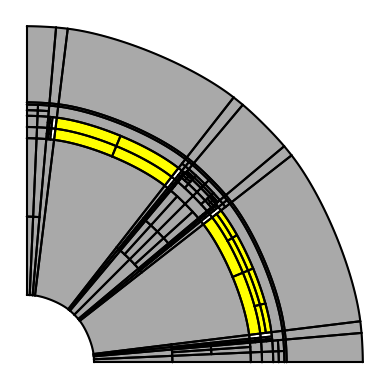

3
Residual contributions took 1.5610148906707764 seconds.
Jump contributions took 3.501234769821167 seconds.
Refinement took 0.4528341293334961 seconds for 27 patches.
Basis setup took 0.12986397743225098 seconds
Prolongation took 0.20584774017333984 seconds


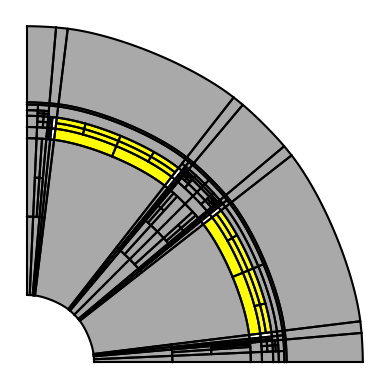

4
Residual contributions took 2.2331032752990723 seconds.
Jump contributions took 5.165830850601196 seconds.
Refinement took 0.7089438438415527 seconds for 30 patches.
Basis setup took 0.19710779190063477 seconds
Prolongation took 0.2328968048095703 seconds


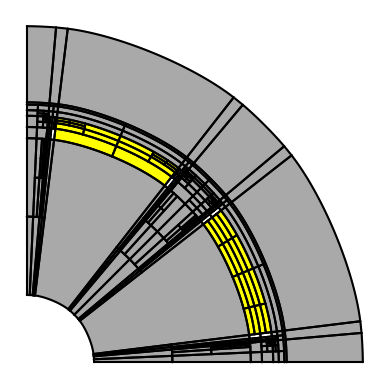

5
Residual contributions took 2.9683480262756348 seconds.
Jump contributions took 6.922528266906738 seconds.
Refinement took 0.8887457847595215 seconds for 32 patches.
Basis setup took 0.24271821975708008 seconds
Prolongation took 0.2550070285797119 seconds


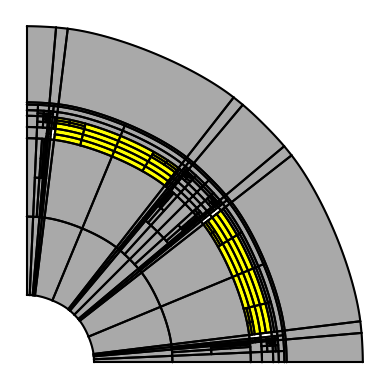

6
Residual contributions took 3.7579379081726074 seconds.
Jump contributions took 8.833176136016846 seconds.
Refinement took 1.1861841678619385 seconds for 35 patches.
Basis setup took 0.34177064895629883 seconds
Prolongation took 0.28218650817871094 seconds


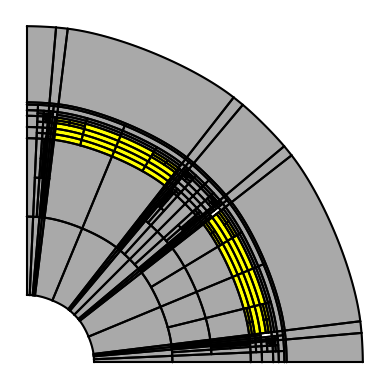

7
Residual contributions took 4.63993763923645 seconds.
Jump contributions took 10.875741004943848 seconds.
Refinement took 1.402369737625122 seconds for 35 patches.
Basis setup took 0.4400496482849121 seconds
Prolongation took 0.28042101860046387 seconds


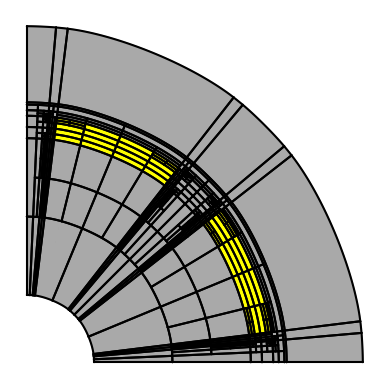

8
Residual contributions took 5.497511148452759 seconds.
Jump contributions took 12.901468276977539 seconds.
Refinement took 1.6617763042449951 seconds for 36 patches.
Basis setup took 0.5560882091522217 seconds
Prolongation took 0.29172205924987793 seconds


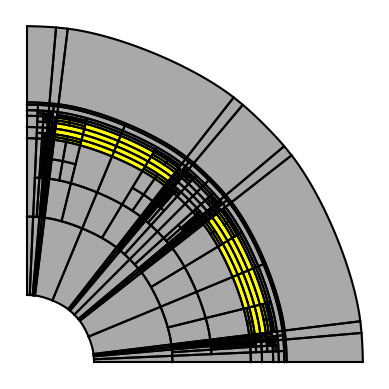

9
Residual contributions took 6.394165515899658 seconds.
Jump contributions took 15.243638038635254 seconds.
Refinement took 2.4187543392181396 seconds for 40 patches.
Basis setup took 0.6902885437011719 seconds
Prolongation took 0.3246753215789795 seconds


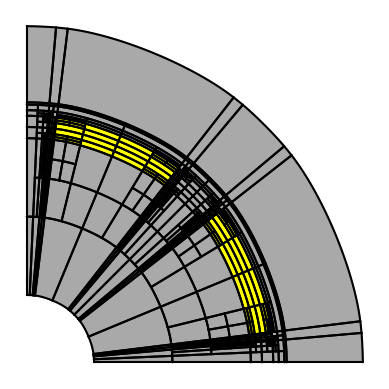

10
Residual contributions took 7.358163595199585 seconds.
Jump contributions took 17.42190933227539 seconds.
Refinement took 2.4315757751464844 seconds for 40 patches.
Basis setup took 0.8403801918029785 seconds
Prolongation took 0.3296947479248047 seconds


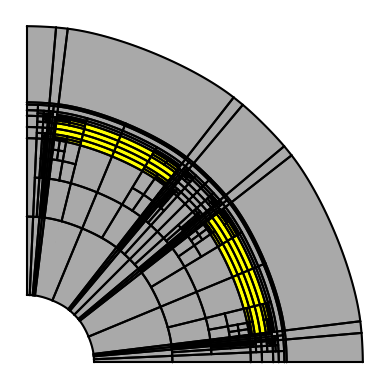

11
Residual contributions took 8.357024192810059 seconds.
Jump contributions took 20.170841217041016 seconds.
Refinement took 3.251793146133423 seconds for 47 patches.
Basis setup took 0.9727137088775635 seconds
Prolongation took 0.3894155025482178 seconds


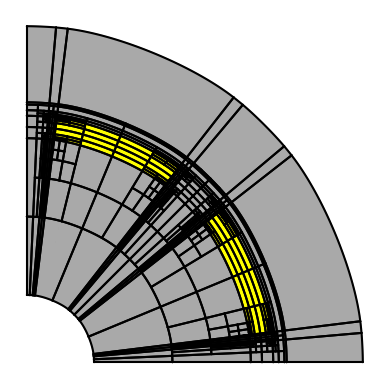

12
Residual contributions took 9.50797986984253 seconds.
Jump contributions took 22.673962354660034 seconds.
Refinement took 4.361622095108032 seconds for 56 patches.
Basis setup took 1.1770436763763428 seconds
Prolongation took 0.46790218353271484 seconds


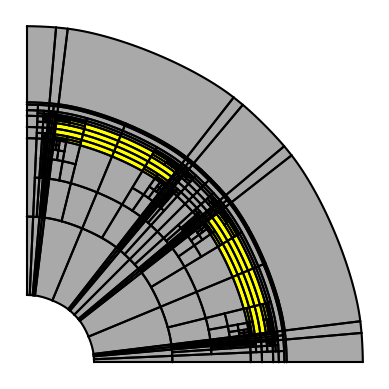

13
Residual contributions took 10.879686117172241 seconds.
Jump contributions took 25.986293077468872 seconds.
Refinement took 5.139605522155762 seconds for 58 patches.
Basis setup took 1.3933024406433105 seconds
Prolongation took 0.487640380859375 seconds


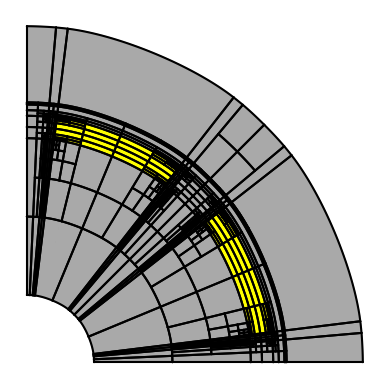

14
Residual contributions took 12.314842939376831 seconds.
Jump contributions took 29.555656909942627 seconds.
Refinement took 5.7422637939453125 seconds for 58 patches.
Basis setup took 1.6812787055969238 seconds
Prolongation took 0.4968843460083008 seconds


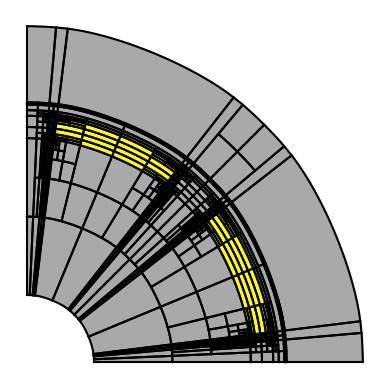

15
Residual contributions took 13.820582866668701 seconds.
Jump contributions took 33.04626178741455 seconds.
Refinement took 8.288905382156372 seconds for 74 patches.
Basis setup took 2.0577783584594727 seconds
Prolongation took 0.6480932235717773 seconds


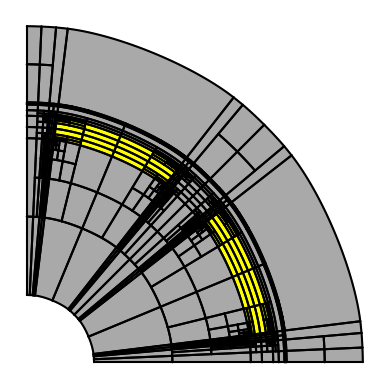

16
Residual contributions took 15.667335033416748 seconds.
Jump contributions took 37.46464014053345 seconds.
Refinement took 10.812944889068604 seconds for 85 patches.
Basis setup took 2.7282824516296387 seconds
Prolongation took 0.7385444641113281 seconds


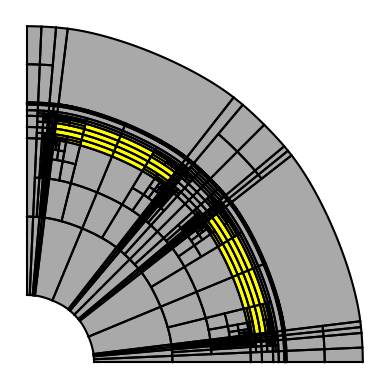

17
Residual contributions took 17.77931022644043 seconds.
Jump contributions took 42.430400371551514 seconds.
Refinement took 14.459885597229004 seconds for 101 patches.
Basis setup took 3.6166841983795166 seconds
Prolongation took 0.9127566814422607 seconds


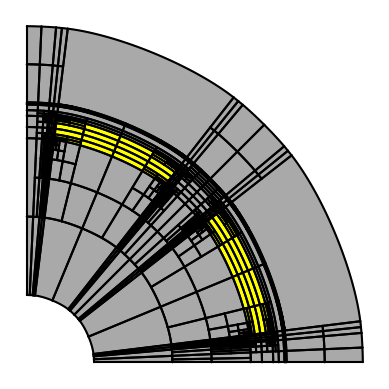

18
Basis setup took 8.676059484481812 seconds
Prolongation took 5.843094348907471 seconds


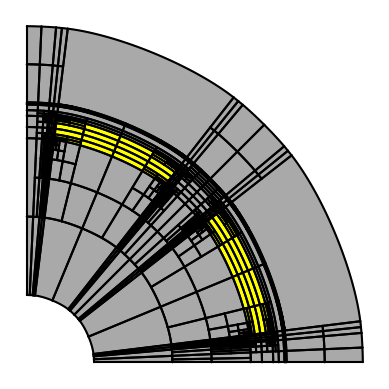

19


In [39]:
deg=4
maxiter=[13,17,20]
M_a=Motor(deg,deg+1,full=False)
MP_a = assemble.Multipatch(M_a, automatch=True)
uh_a=[]
P_a=[]
err_ind=[]


numdofs_a =np.zeros(maxiter[deg-2])
err_est=np.zeros(maxiter[deg-2])

for i in range(maxiter[deg-2]):
    MP_a.mesh.draw(color={'M1':'yellow', 'M2':'yellow','Fe':'darkgrey','Air':'white'},bwidth=0.01)
    plt.axis('off');
    plt.axis('scaled');
    plt.savefig('/home/wolfman/Pictures/Motor/p2/i'+str(i)+'.png',bbox_inches='tight');
    plt.show()
    print(i)
    bcs = MP_a.compute_dirichlet_bcs({'D':0.})
    Ah_a = sum([MP_a.assemble_volume(vform.stiffness_vf(2,a=nu[k]),domain_id=k) for k in nu])
    F = sum([MP_a.assemble_volume('(j * v - inner(Ma_T, grad(v))) * dx', arity=1, domain_id=k, Ma_T=Ma_T[k], j=j[k], physical=True) for k in j],axis=0)
    Kh_a = MP_a.assemble_volume(vform.stiffness_vf(2))
    Mh_a = MP_a.assemble_volume(vform.mass_vf(2))
    #print(Ah.shape)
    LS = assemble.RestrictedLinearSystem(Ah_a, F, bcs)
    uh_a.append(LS.complete((cholesky(LS.A.tocsc()))(LS.b)))
    numdofs_a[i] = MP_a.numdofs
    #print(MP_a.numdofs)
    
    if i < maxiter[deg-2]-2 :
        err_ind.append(adap.PoissonEstimator(MP_a,uh_a[-1],f=j,a=nu, M=Ma_T, neu_data={'N':0.}, physical=True))
        err_est[i] = norm(err_ind[-1])
        marked_patches = adap.doerfler_marking(err_ind[-1], 0.9)
        marked_patches = {p:None for p in marked_patches}
        P_a.append(MP_a.h_refine(h_ref=marked_patches, return_P=True))
        MP_a.mesh.sanity_check()
        MP_a.sanity_check()
        #MP_a.mesh.draw(plt.figure())
    elif i == maxiter[deg-2]-2:
        P_a.append(MP_a.p_refine(p_inc=1, return_P=True))
    else:
        pass
    
for k in reversed(range(1,len(P_a))):
    P_a[k-1]=P_a[k]@P_a[k-1]
    
L2err_a = np.zeros(maxiter[deg-2])
H1err_a = np.zeros(maxiter[deg-2])
Aherr_a = np.zeros(maxiter[deg-2])
for i in range(len(uh_a)-1):
    eh = P_a[i]@uh_a[i]-uh_a[-1]
    L2err_a[i] = eh @ Mh_a @ eh
    H1err_a[i] = eh @ Kh_a @ eh + L2err_a[-1]
    Aherr_a[i] = eh @ Ah_a @ eh
    
L2err_a = sqrt(L2err_a)
H1err_a = sqrt(H1err_a)
Aherr_a = sqrt(Aherr_a)

np.savetxt('Mp'+str(deg)+'n'+str(deg+1)+'.txt', np.c_[[numdofs_a,H1err_a,L2err_a,Aherr_a]])

In [40]:
MP_a.numdofs

736528

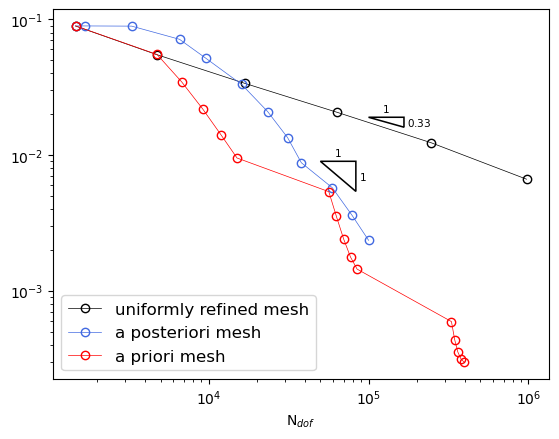

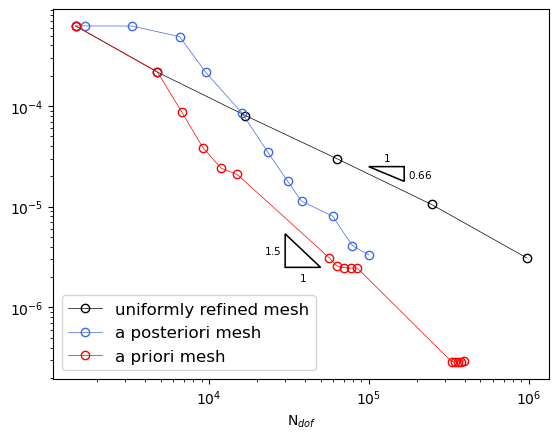

In [137]:
deg=2
[numdofs,H1err,L2err,err_est]=np.loadtxt('Mp'+str(deg)+'n'+str(deg+1)+'uni.txt')
[numdofs_a,H1err_a,L2err_a,Aherr_a]=np.loadtxt('Mp'+str(deg)+'n'+str(deg+1)+'.txt')
[numdofs_geo,H1err_geo,L2err_geo,Aherr_geo]=np.loadtxt('Mp'+str(deg)+'n'+str(deg+1)+'geo.txt')

fig, ax = plt.subplots()
plt.loglog(numdofs[:-1], H1err[:-1], 'o-',color='black',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs_a[:-1], H1err_a[:-1], 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[:-1], err_est[:-1], 'x-',color='red',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs_geo[:-4], H1err_geo[:-4], 'o-',color='red',linewidth=0.5, markerfacecolor='none')

plt.legend(['uniformly refined mesh','a posteriori mesh','a priori mesh'],loc='lower left',prop={'size': 12})
plt.xlabel("N$_{dof}$")

draw_loglog_slope(fig,ax,(1e5,1.9*1e-2),1,0.33,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
draw_loglog_slope(fig,ax,(5*1e4,9*1e-3),1,int(deg/2) if deg%2==0 else deg/2,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)

plt.savefig('/home/wolfman/Pictures/Motor/p'+str(deg)+'/Mp'+str(deg)+'n'+str(deg+1)+'H1.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
plt.loglog(numdofs[:-1], L2err[:-1], 'o-',color='black',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs_a[:-1], L2err_a[:-1], 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs_geo[:-4], L2err_geo[:-4], 'o-',color='red',linewidth=0.5, markerfacecolor='none')

plt.legend(['uniformly refined mesh','a posteriori mesh','a priori mesh'],loc='lower left',prop={'size': 12})
plt.xlabel("N$_{dof}$")

draw_loglog_slope(fig,ax,(1e5,2.5*1e-5),1,0.66,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
draw_loglog_slope(fig,ax,(5*1e4,2.5*1e-6),1,int((deg+1)/2) if (deg+1)%2==0 else (deg+1)/2,inverted=True, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)

#fig, ax = plt.subplots()
# plt.loglog(numdofs[:-1], Aherr[:-1], 'o-',color='black',linewidth=0.5, markerfacecolor='none')
# plt.loglog(numdofs_a[:-1], Aherr_a[:-1], 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
# plt.loglog(numdofs_geo[:-1], Aherr_geo[:-1], 'o-',color='red',linewidth=0.5, markerfacecolor='none')

plt.savefig('/home/wolfman/Pictures/Motor/p'+str(deg)+'/Lp'+str(deg)+'n'+str(deg+1)+'L2.pdf', bbox_inches='tight')
plt.show()

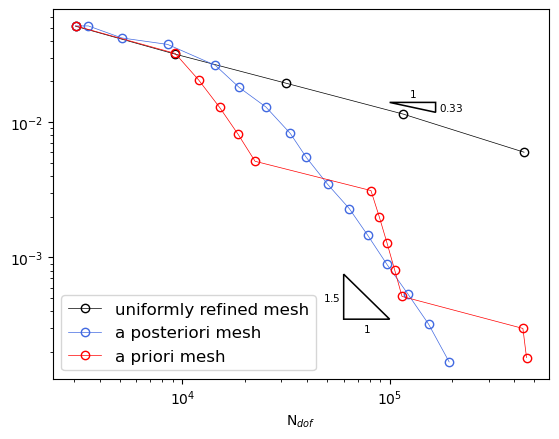

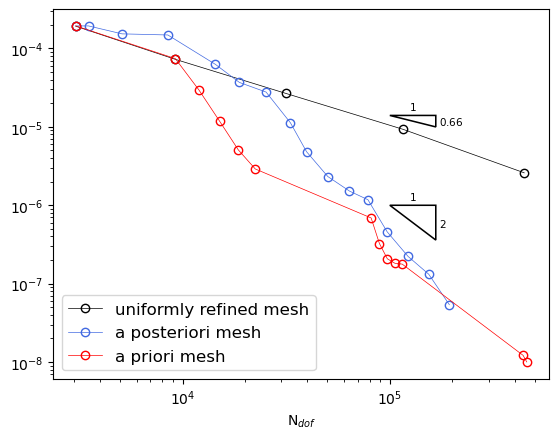

In [138]:
deg=3
[numdofs,H1err,L2err,err_est]=np.loadtxt('Mp'+str(deg)+'n'+str(deg+1)+'uni.txt')
[numdofs_a,H1err_a,L2err_a,Aherr_a]=np.loadtxt('Mp'+str(deg)+'n'+str(deg+1)+'.txt')
[numdofs_geo,H1err_geo,L2err_geo,Aherr_geo]=np.loadtxt('Mp'+str(deg)+'n'+str(deg+1)+'geo.txt')

fig, ax = plt.subplots()
plt.loglog(numdofs[:-1], H1err[:-1], 'o-',color='black',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs_a[:-1], H1err_a[:-1], 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[:-1], err_est[:-1], 'x-',color='red',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs_geo[:-2], H1err_geo[:-2], 'o-',color='red',linewidth=0.5, markerfacecolor='none')

plt.legend(['uniformly refined mesh','a posteriori mesh','a priori mesh'],loc='lower left',prop={'size': 12})
plt.xlabel("N$_{dof}$")

draw_loglog_slope(fig,ax,(1e5,1.4*1e-2),1,0.33,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
draw_loglog_slope(fig,ax,(1e5,3.5*1e-4),1,int(deg/2) if deg%2==0 else deg/2,inverted=True, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)

plt.savefig('/home/wolfman/Pictures/Motor/p'+str(deg)+'/Mp'+str(deg)+'n'+str(deg+1)+'H1.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
plt.loglog(numdofs[:-1], L2err[:-1], 'o-',color='black',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs_a[:-1], L2err_a[:-1], 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs_geo[:-2], L2err_geo[:-2], 'o-',color='red',linewidth=0.5, markerfacecolor='none')

plt.legend(['uniformly refined mesh','a posteriori mesh','a priori mesh'],loc='lower left',prop={'size': 12})
plt.xlabel("N$_{dof}$")

draw_loglog_slope(fig,ax,(1e5,1.4*1e-5),1,0.66,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
draw_loglog_slope(fig,ax,(1e5,1e-6),1,int((deg+1)/2) if (deg+1)%2==0 else (deg+1)/2,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)

plt.savefig('/home/wolfman/Pictures/Motor/p'+str(deg)+'/Lp'+str(deg)+'n'+str(deg+1)+'L2.pdf', bbox_inches='tight')
plt.show()

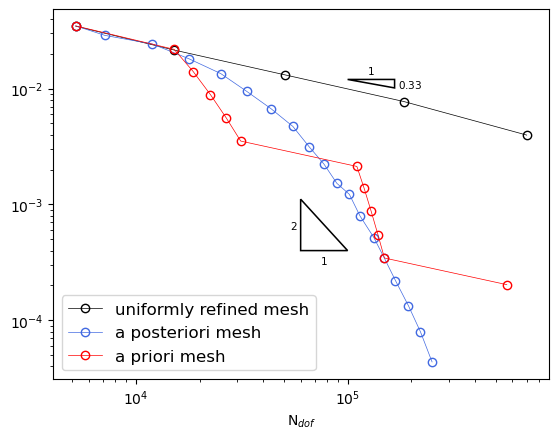

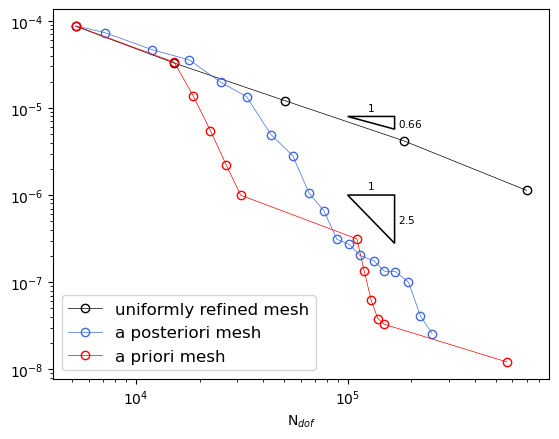

In [139]:
deg=4
[numdofs,H1err,L2err,err_est]=np.loadtxt('Mp'+str(deg)+'n'+str(deg+1)+'uni.txt')
[numdofs_a,H1err_a,L2err_a,Aherr_a]=np.loadtxt('Mp'+str(deg)+'n'+str(deg+1)+'.txt')
[numdofs_geo,H1err_geo,L2err_geo,Aherr_geo]=np.loadtxt('Mp'+str(deg)+'n'+str(deg+1)+'geo.txt')
fig, ax = plt.subplots()

plt.loglog(numdofs[:-1], H1err[:-1], 'o-',color='black',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs_a[:-1], H1err_a[:-1], 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
#plt.loglog(numdofs_a[:-1], err_est[:-1], 'x-',color='red',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs_geo[:-3], H1err_geo[:-3], 'o-',color='red',linewidth=0.5, markerfacecolor='none')

plt.legend(['uniformly refined mesh','a posteriori mesh','a priori mesh'],loc='lower left',prop={'size': 12})
plt.xlabel("N$_{dof}$")

draw_loglog_slope(fig,ax,(1e5,1.2*1e-2),1,0.33,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
draw_loglog_slope(fig,ax,(1e5,4*1e-4),1,int(deg/2) if deg%2==0 else deg/2,inverted=True, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)

plt.savefig('/home/wolfman/Pictures/Motor/p'+str(deg)+'/Mp'+str(deg)+'n'+str(deg+1)+'H1.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
plt.loglog(numdofs[:-1], L2err[:-1], 'o-',color='black',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs_a[:-1], L2err_a[:-1], 'o-',color='royalblue',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs_geo[:-3], L2err_geo[:-3], 'o-',color='red',linewidth=0.5, markerfacecolor='none')

plt.legend(['uniformly refined mesh','a posteriori mesh','a priori mesh'],loc='lower left',prop={'size': 12})
plt.xlabel("N$_{dof}$")

draw_loglog_slope(fig,ax,(1e5,8*1e-6),1,0.66,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)
draw_loglog_slope(fig,ax,(1e5,1e-6),1,int((deg+1)/2) if (deg+1)%2==0 else (deg+1)/2,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)

plt.savefig('/home/wolfman/Pictures/Motor/p'+str(deg)+'/Lp'+str(deg)+'n'+str(deg+1)+'L2.pdf', bbox_inches='tight')
plt.show()

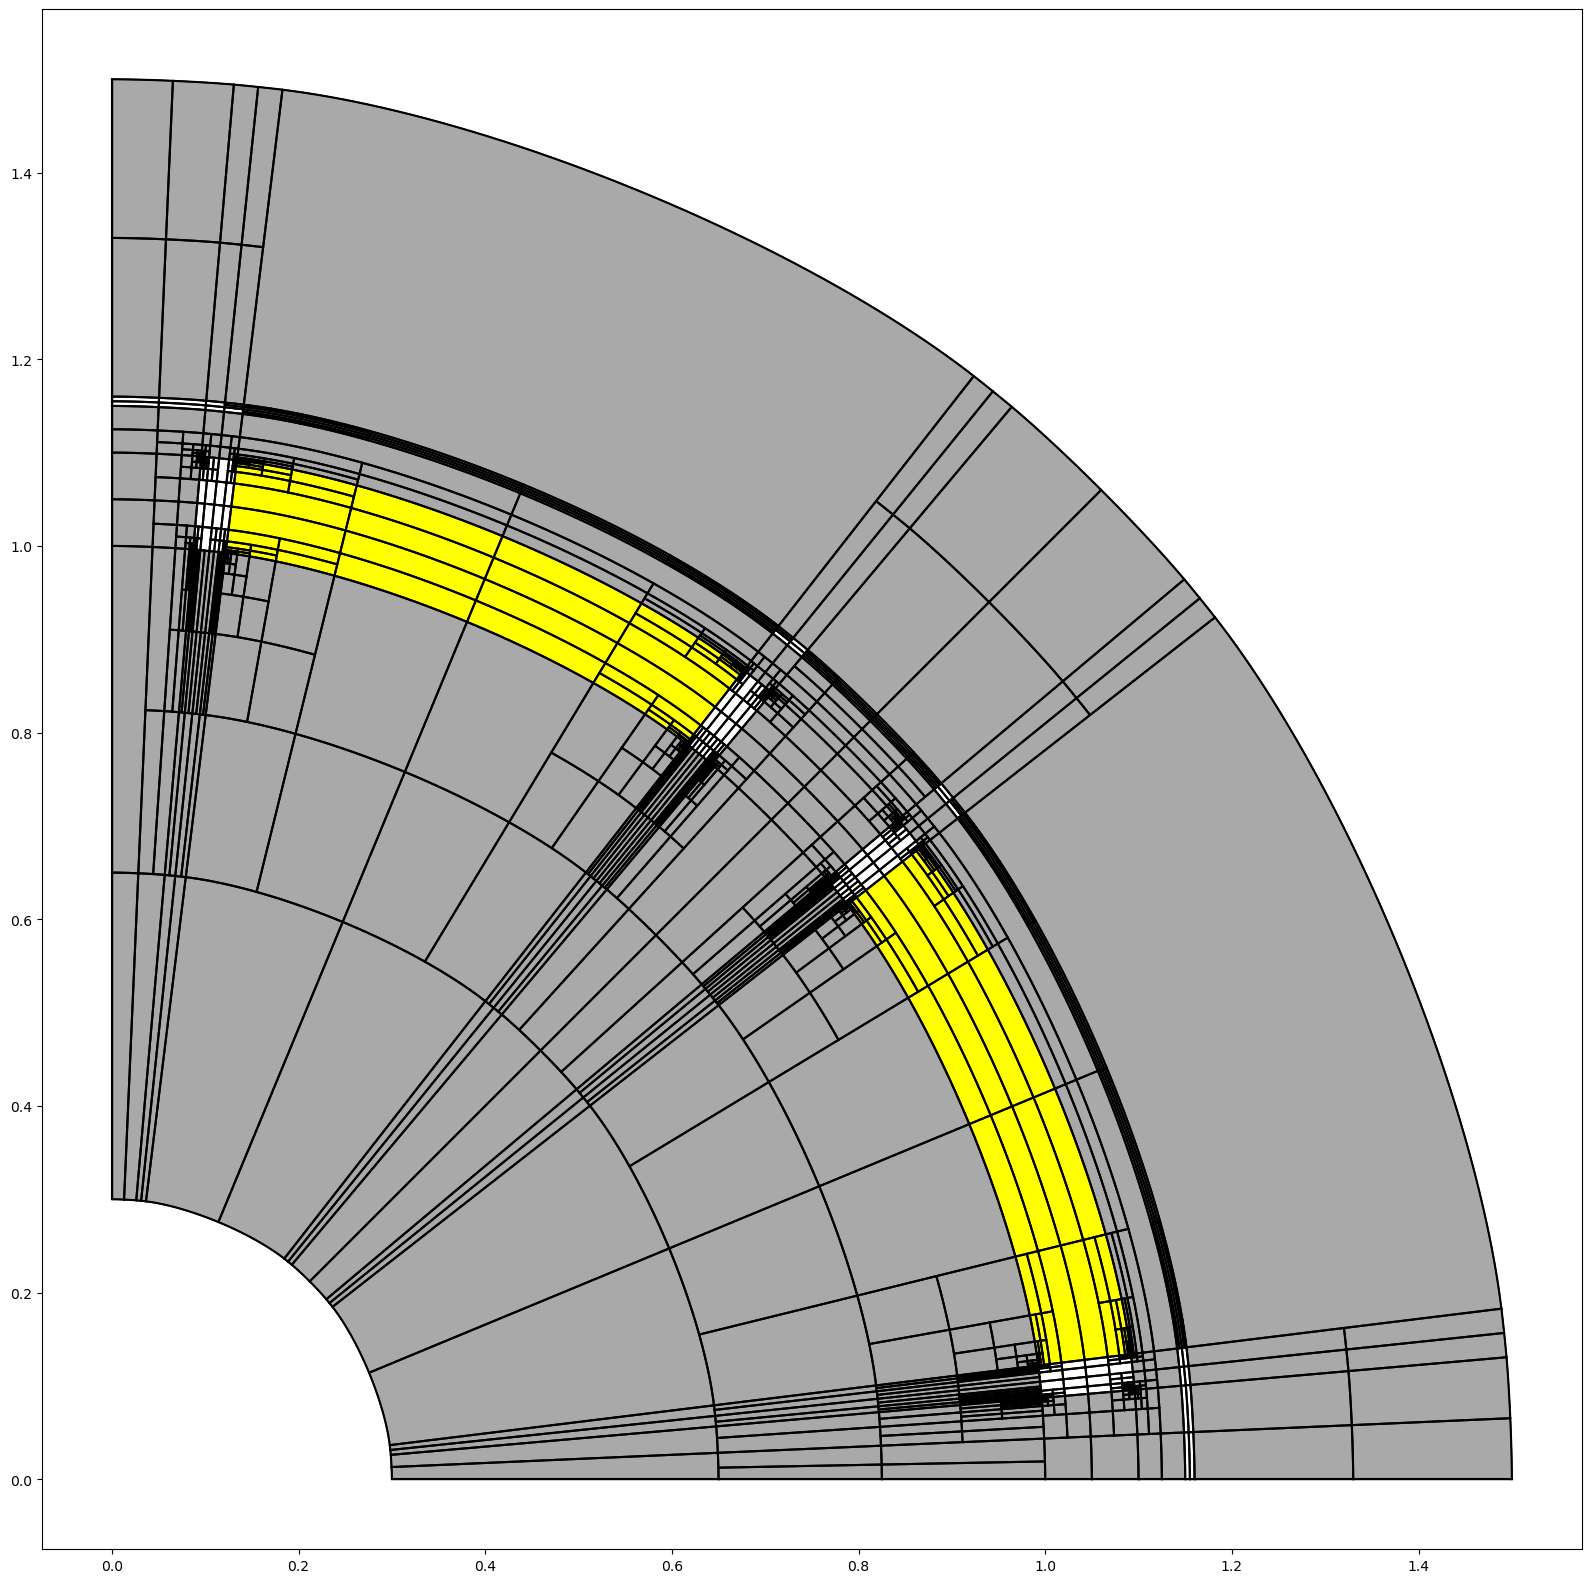

In [143]:
MP_a.mesh.draw(figsize=(20,20),color={'M1':'yellow', 'M2':'yellow','Fe':'darkgrey','Air':'white'})

In [148]:
len(MP_a.mesh.domains['Air'])

736

In [8]:
marked=adap.doerfler_marking(err,theta=0.8)

In [20]:
Ma_T['M1'](1,1)

(-663216.4391580891, 663216.4391580891)

In [18]:
deg=2
M=Motor(deg,deg+1,full=False)
MP=assemble.Multipatch(M, automatch=True)
bcs = MP.compute_dirichlet_bcs({0:0.})
Ah = sum([MP.assemble_volume(vform.stiffness_vf(2,a=nu[k]),domain_id=k) for k in nu])
F = sum([MP.assemble_volume('(j * v - inner(Ma_T, grad(v))) * dx', arity=1, domain_id=k, Ma_T=Ma_T[k], j=j[k], physical=True) for k in j],axis=0)
LS = assemble.RestrictedLinearSystem(Ah, F, bcs)
uh = LS.complete((cholesky(LS.A.tocsc()))(LS.b))

Detecting interfaces took 2.6801695823669434 seconds.
Basis setup took 0.013472318649291992 seconds


In [40]:
M=Motor(4,5)

Detecting interfaces took 2.7163403034210205 seconds.


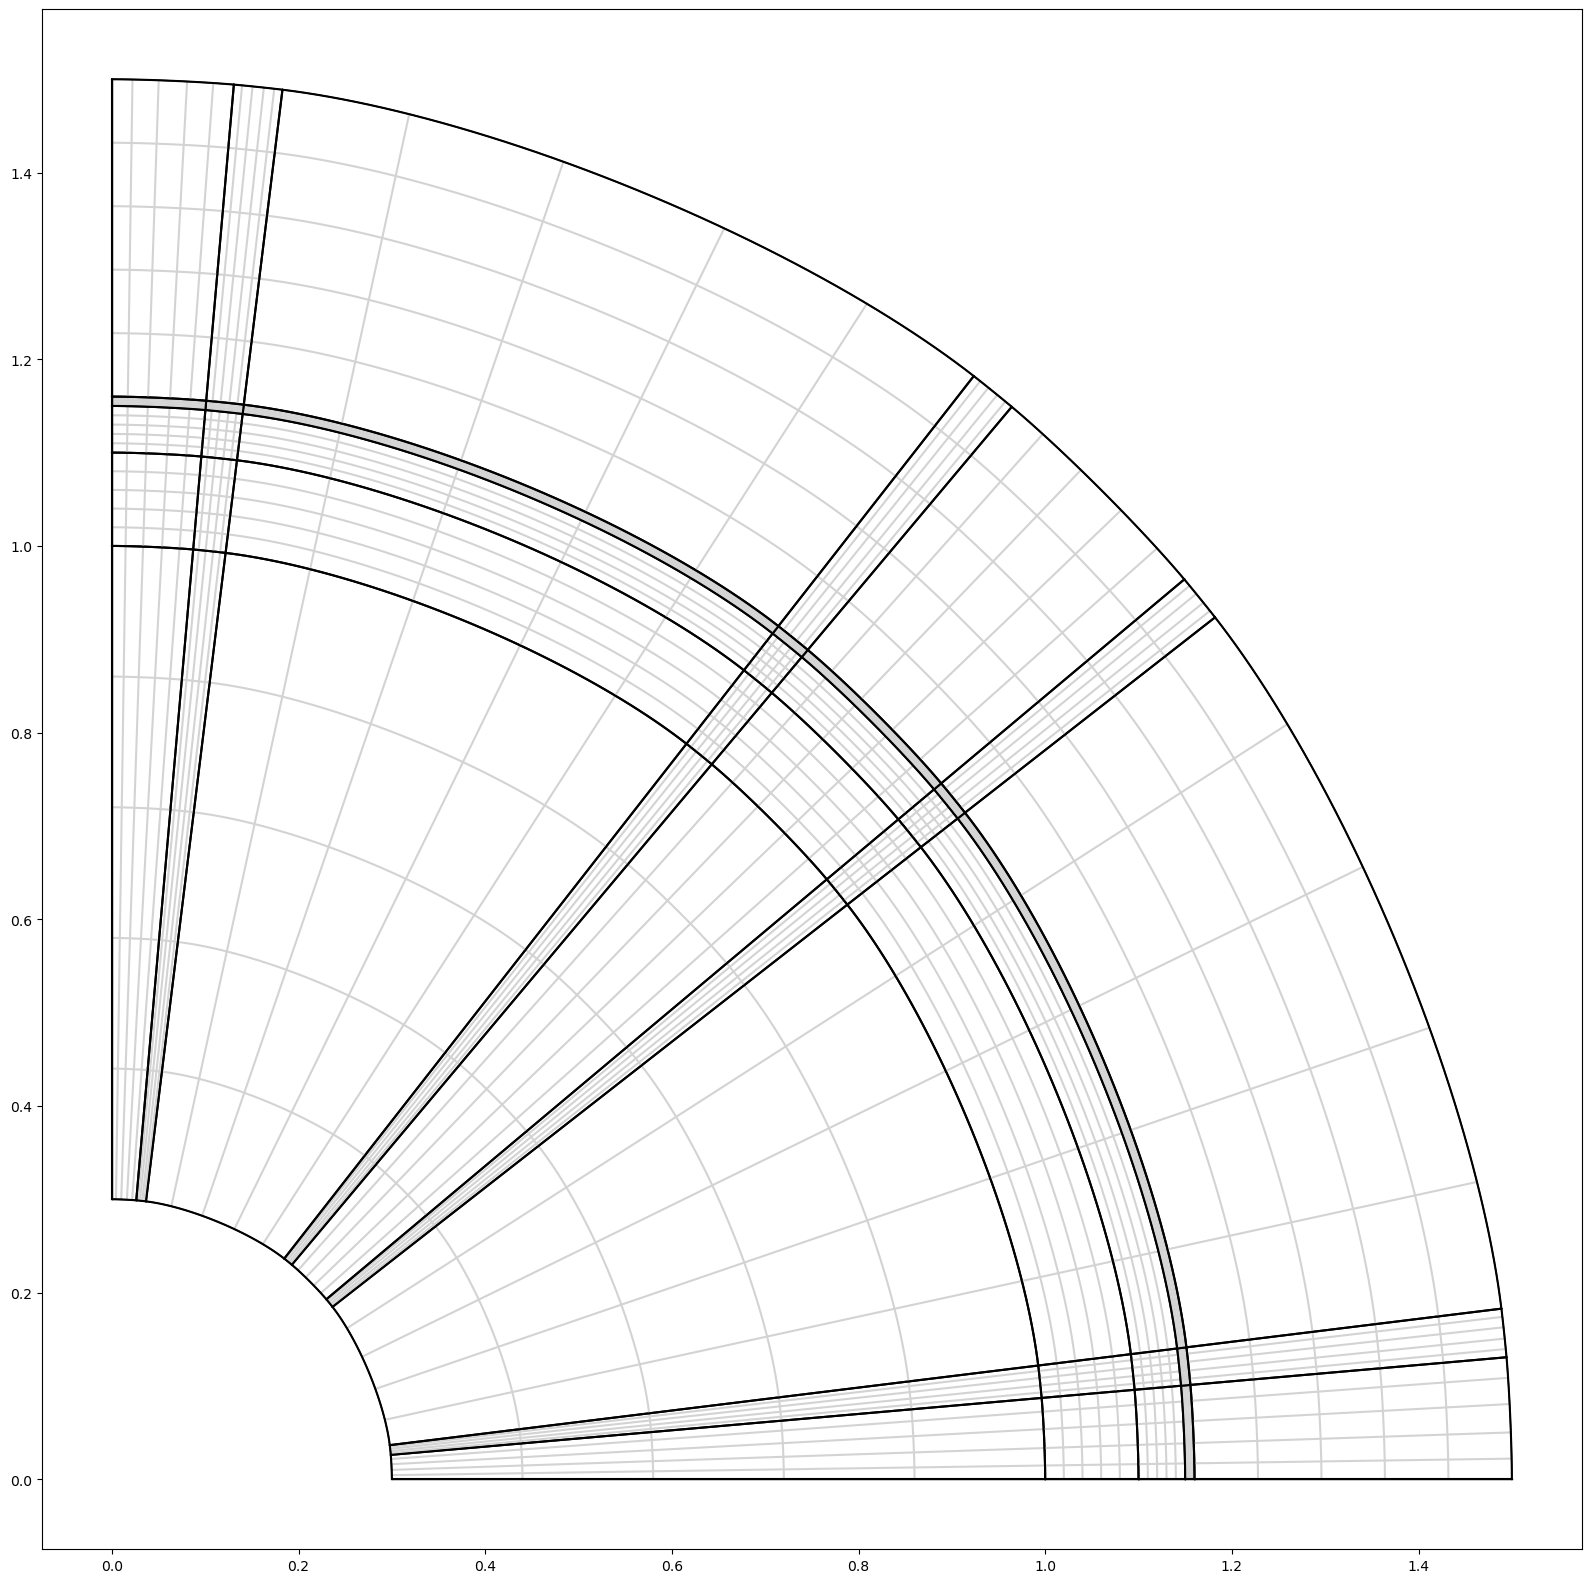

In [41]:
M.draw(figsize=(20,20),knots=True)
#plt.axis('off')
#MP.plot(uh, cmap='gnuplot2', axis='scaled')
#plt.axis('off')

In [19]:
M=topology.PatchMesh([(2*(bspline.make_knots(2,0.0,1.0,4),),geometry.unit_square())])
MP=assemble.Multipatch(M, automatch=True)

Basis setup took 0.0022804737091064453 seconds


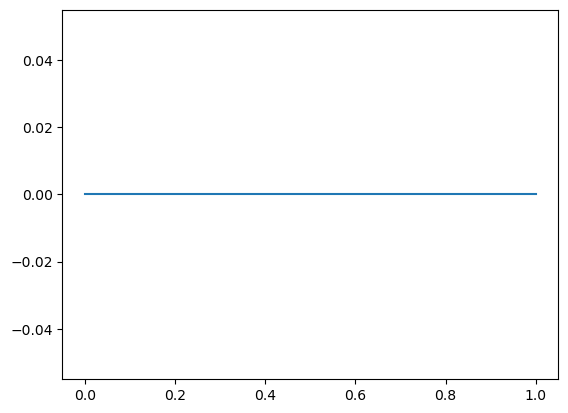

In [21]:
plt.plot([0.0,0.0])

In [3]:
u_ = MP.L2projection(lambda x,y: x**2+y**2)

AttributeError: 'Figure' object has no attribute 'get_array'

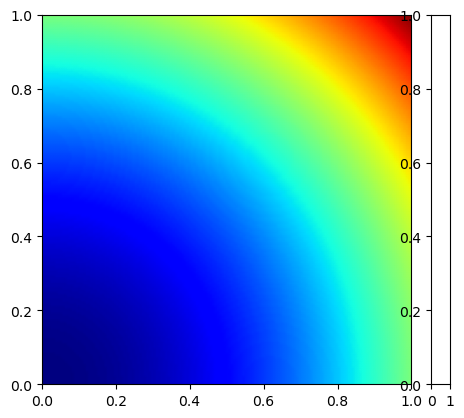

In [4]:
MP.plot(plt.figure(),u_)

In [5]:
fig=plt.figure()

<Figure size 640x480 with 0 Axes>